# USB Modeling 
  - Input
    - INFOSYS_POPULATION_new.xlsx
      - The data was originally from INFOSYS_POPULATION.xlsx and applied the code USB_Data_wrangling.ipynb to impute missing values for categorical data 
  - Data Prepration  
    -  Create a new variable ElRmFl_ind to replace 'Existing_Limit', 'Request_Amount', 'Final_Limit’ 
       - ElRmEQFl 
          - if 'Existing_Limit' + 'Request_Amount' = 'Final_Limit'
      - ElRmNEFl 
          - if 'Existing_Limit' + 'Request_Amount' != 'Final_Limit'
  - Apply TargetEncoder to convert categorical variables to numeric data
  - Apply MinMaxScaler to nomalize data 
  - Apply KNNImputer to impute SBFE_Score and CC_Score  
  - Apply ADASYN to handle the imblance data set
  - Get  correlation among feature variables
    - Only include one feature if correlation coefficient > 0.8
      - The correlation coefficient between orporate_Card and one_card is -0.82.  Not include one_card for the modelin 
    - The correlation coefficient between target and ElRmFl_ind is 0.98. Not include ElRmFl_ind for the modeling 
  - Apply cross_val_score to various models and select the winner 
  - Build LogisticRegression model and evaluate the model
    - The roc_auc is 0.8063
  - Build XGBClassifier model and evaluate the model
    - The roc_auc is 0.9257
  - Notes
    - use 'pip install category-encoders' to resove "No module named 'category_encoders'" 
    - use 'pip install category-encoders --user' to resolve "No module named 'imblearn'"
    - use 'pip install xgboost' to resolve "No module named 'xgboost'"
   - Author: Sophia Yue 
   - Written Date: Oct 07, 2022 
 - Enhancenment oct 27, 2022  
   - The  IV for final limit is high, will not drop final limit    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import TargetEncoder
from imblearn.over_sampling import ADASYN
from sklearn.impute import KNNImputer


from numpy import mean
from numpy import std
from numpy import absolute

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFECV

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Ignore warning message

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option( 'display.max_columns', 10 )
pd.set_option('precision', 6)
pd.set_option('max_colwidth', 20)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', lambda x: '%.5f' %x)
#pd.set_printoptions(suppress = True)

In [4]:
## Evaluation
def mdl_eva(X_test, y_test, mdl, mdl_desc):
    """
     Purpose: Evaluate model and print confusion matric and classification report
     Parameters:
       Input:
       X_test: Trian test
       y_test: Test data for validation
       mdl: Model to be evaluated
       mdl_desc: Model description
    """
    print(f'{mdl_desc} Model Evalation')
    predictions = mdl.predict(X_test)
    y_pred = predictions 
    print("Accuracy Score :",metrics.accuracy_score(y_test, y_pred))
    print("Precision Score:",metrics.precision_score(y_test, y_pred))
    print("Recall Score   :",metrics.recall_score(y_test, y_pred)) 
    print("Auc Score      :",metrics.roc_auc_score(y_test, y_pred)) 
    
    print(classification_report(y_test,predictions))
    cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=[0, 1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1'])
    print(cmtx)
    
    # Draw ROC
    # AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.
    y_pred_proba = mdl.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    plt.title("ROC for " + mdl_desc)
    plt.plot(fpr,tpr,label=" auc="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc=4)
    plt.show()

## data preparation
   - Replace column 'Decioned' by column 'target'
     - Creae a new column 'target' from 'Decision'
        - 'Declined': 1
        - 'Approved':0
     -  Remove 2 missing values from 'Channel'
     -  Remove 'NAICS_Desc', 'NAICS_Cd', 'Revw_Id', 'Revw_Month'
        - will not use these colmns for modeling

In [5]:
path = 'C:\\Users\\sophia.yue\\Infosys\\Sandeep Project\\'
df = pd.read_excel(path + "INFOSYS_POPULATION_new.xlsx", sheet_name = 'INFOSYS_POPULATION_new', engine = 'openpyxl' )
#df.head(3).T
#df.head()
#df.shape
#df.describe()
#df.info()

df.Decision.value_counts()             
targ_dict = {'Declined': 1, 'Approved':0 }
df['target'] = [targ_dict[yy] for yy in df.Decision]
df.target.value_counts() 
df = df.dropna(subset = ['Channel'])  # drop missing values from channel

df['ElRmFl_ind']  = list(map(lambda x, y, z:'ElRmEqFl' if x + y == z else 'ElRmNEFl', df['Existing_Limit'], df['Request_Amount'], df['Final_Limit']))
l_col_rem = ['NAICS_Desc', 'NAICS_Cd', 'Revw_Id', 'Revw_Month', 'Decision', 'Existing_Limit', 'Request_Amount'] # not drop 'Final_Limit'
df.drop(l_col_rem, axis = 1,  inplace = True)
card_typ = ['Corporate_Card','Purchasing_Card','One_Card','Other_NonBankCard']
#df.astype({'Corporate_Card':'object',
df.astype({'Corporate_Card':'object',
           'Purchasing_Card':'object',
           'One_Card':'object',
           'Other_NonBankCard':'object'})
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2481 entries, 0 to 2482
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Org_Struc_Desc                 2481 non-null   object 
 1   Revw_Quarter                   2481 non-null   object 
 2   Scored_Flag                    2481 non-null   object 
 3   Elan_Flag                      2481 non-null   object 
 4   CLI_or_New_Prod_Flag           2481 non-null   object 
 5   Channel                        2481 non-null   object 
 6   Corporate_Card                 2481 non-null   int64  
 7   Purchasing_Card                2481 non-null   int64  
 8   One_Card                       2481 non-null   int64  
 9   Other_NonBankCard              2481 non-null   int64  
 10  Scored_Rec_Decision            2481 non-null   object 
 11  SBFE_Score                     2031 non-null   float64
 12  CC_Score                       1919 non-null   f

In [6]:
df['target'].value_counts()

0    1848
1     633
Name: target, dtype: int64

In [7]:
df['ElRmFl_ind'].value_counts()

ElRmEqFl    1813
ElRmNEFl     668
Name: ElRmFl_ind, dtype: int64

## Get columns for type with objective and numeric   
 - l_col_obj : get features with datatype = obj
   - include card number in l_col_obj


In [8]:
l_col_obj = df.dtypes[df.dtypes == 'O'].index.tolist() 
print(l_col_obj)

['Org_Struc_Desc', 'Revw_Quarter', 'Scored_Flag', 'Elan_Flag', 'CLI_or_New_Prod_Flag', 'Channel', 'Scored_Rec_Decision', 'Financial_Template_Found_Flag', 'ElRmFl_ind']


## Categorical feature encoding 
  - Invoke 'impute_cat' to impute missing values
  - Define a function 'tar_enc' to use target encoding to convert categorical feature to numerical feature
  - Will apply to all categorical features


In [9]:
#Apply target encoding for df
for feature in l_col_obj:
    tenc=ce.TargetEncoder() 
    df_fea =tenc.fit_transform(df[feature],df['target'])
    df[feature] = df_fea 

## scale the numerical features

In [10]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df.head(3)

,Org_Struc_Desc,Revw_Quarter,Scored_Flag,Elan_Flag,CLI_or_New_Prod_Flag,...,CC_Score,Financial_Template_Found_Flag,Final_Limit,target,ElRmFl_ind
0,0.26812,0.38418,1.00000,0.00000,0.00000,...,NaN,1.00000,0.28000,0.00000,0.00000
1,0.17471,0.38418,1.00000,0.00000,0.00000,...,0.50781,1.00000,0.10000,1.00000,1.00000
2,0.00000,0.38418,1.00000,0.00000,1.00000,...,0.54911,1.00000,1.00000,0.00000,0.00000


## Impute numerical feature

In [11]:
imputer = KNNImputer(n_neighbors=5)
#df =  pd.DataFrame(imputer.fit_transform(df),columns = df.columns)       
#df['SBFE_Score'] = pd.DataFrame(imputer.fit_transform(df),columns = 'SBFE_Score')
df["SBFE_Score"] = imputer.fit_transform(df[["SBFE_Score"]]).ravel() # Ravel: Return a contiguous flattened array
df['CC_Score'] = imputer.fit_transform(df[['CC_Score']]).ravel()
df.head(3)                   

,Org_Struc_Desc,Revw_Quarter,Scored_Flag,Elan_Flag,CLI_or_New_Prod_Flag,...,CC_Score,Financial_Template_Found_Flag,Final_Limit,target,ElRmFl_ind
0,0.26812,0.38418,1.00000,0.00000,0.00000,...,0.51420,1.00000,0.28000,0.00000,0.00000
1,0.17471,0.38418,1.00000,0.00000,0.00000,...,0.50781,1.00000,0.10000,1.00000,1.00000
2,0.00000,0.38418,1.00000,0.00000,1.00000,...,0.54911,1.00000,1.00000,0.00000,0.00000


In [12]:
df.isnull().any()

Org_Struc_Desc                   False
Revw_Quarter                     False
Scored_Flag                      False
Elan_Flag                        False
CLI_or_New_Prod_Flag             False
Channel                          False
Corporate_Card                   False
Purchasing_Card                  False
One_Card                         False
Other_NonBankCard                False
Scored_Rec_Decision              False
SBFE_Score                       False
CC_Score                         False
Financial_Template_Found_Flag    False
Final_Limit                      False
target                           False
ElRmFl_ind                       False
dtype: bool

## ADASYN - to handle imbalance data
  - The ADASYN (adaptive synthetic sampling) approach
  - uses a weighted distribution for different minority class examples according to their level of difficulty in learning
    - where more synthetic data is generated for minority class examples that are harder to learn.
    - fit_sample had been ewplaced by fit_resample  
    - type(X_resampled) is a dataFrame
    - type(X_resampled) is a series

In [13]:
y = df["target"]
X = df.drop('target', axis = 1)
ada = ADASYN() 
X_resampled, y_resampled = ada.fit_resample(X, y) 


## check correlation

In [14]:

# The correlation between target and ElRmFl_ind is 0.98. Not include ElRmFl_ind for the modeling 
col_ElRmFl_ind = X_resampled['ElRmFl_ind']
cor = col_ElRmFl_ind.corr(y_resampled )
cor

0.9813003159393353

<AxesSubplot:>

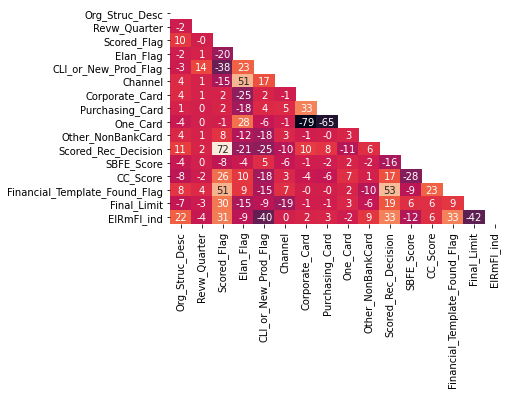

In [15]:

correlation_matrix = X_resampled.corr()
mask = np.zeros_like(correlation_matrix , dtype=np.bool) # Create a mask from correlations with all value = "False" 
# Create a mask from correlations with all value = "True" for element in the upper-triangle of arr (include diagonal and above the diagonal)  
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation_matrix  * 100, annot=True, fmt='.0f', mask=mask, cbar = False)

In [16]:
correlated_features = set()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

correlated_features.add('ElRmFl_ind') 
X_resampled.drop(labels=correlated_features, axis=1, inplace=True)
           

In [17]:
X_resampled.columns

Index(['Org_Struc_Desc', 'Revw_Quarter', 'Scored_Flag', 'Elan_Flag', 'CLI_or_New_Prod_Flag', 'Channel',
       'Corporate_Card', 'Purchasing_Card', 'One_Card', 'Other_NonBankCard', 'Scored_Rec_Decision', 'SBFE_Score',
       'CC_Score', 'Financial_Template_Found_Flag', 'Final_Limit'],
      dtype='object')

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.20, 
                                                    random_state=101)

##  Apply cross_val_score to various models and select the winner

In [19]:
models = []
#models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier(learning_rate=0.1,  max_depth= 5)))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results  = cross_val_score(model, X_resampled, y_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LGR: 0.933720 (0.011901)
LDA: 0.930217 (0.011978)
KNN: 0.977433 (0.005461)
CART: 0.970059 (0.009473)
NB: 0.856129 (0.020360)
XGB: 0.997853 (0.001067)
SVM: 0.946945 (0.010981)


##  XGBClassifier is the winner
    - will build LogisticRegression Model and XGBClassifier model

###  Build LogisticRegression Model & evaluation


In [20]:
lgr = LogisticRegression() 
# fit the model
lgr.fit(X_train, y_train)
# get importance
feature_importance = lgr.coef_[0]


### Summarize coefficients 

In [21]:

pd.DataFrame(feature_importance, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
Org_Struc_Desc,3.83533
Financial_Template_Found_Flag,1.81723
Scored_Rec_Decision,0.89876
Scored_Flag,0.88306
One_Card,0.76229
Purchasing_Card,0.21590
Channel,-0.08346
Revw_Quarter,-0.32915
Corporate_Card,-0.38330
Elan_Flag,-0.52276


In [22]:
coef_aft_exp = np.exp(feature_importance)
pd.DataFrame(coef_aft_exp, 
             X_train.columns, 
             columns=['coef_aft_exp'])\
            .sort_values(by='coef_aft_exp', ascending=False)

,coef_aft_exp
Org_Struc_Desc,46.30854
Financial_Template_Found_Flag,6.15480
Scored_Rec_Decision,2.45654
Scored_Flag,2.41829
One_Card,2.14319
Purchasing_Card,1.24097
Channel,0.91993
Revw_Quarter,0.71953
Corporate_Card,0.68161
Elan_Flag,0.59288


### Evaluate model

LogisticRegression Model Evalation
Accuracy Score : 0.8773584905660378
Precision Score: 0.8673740053050398
Recall Score   : 0.8885869565217391
Auc Score      : 0.8774485584747734
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       374
         1.0       0.87      0.89      0.88       368

    accuracy                           0.88       742
   macro avg       0.88      0.88      0.88       742
weighted avg       0.88      0.88      0.88       742

        pred:0  pred:1
true:0     324      50
true:1      41     327


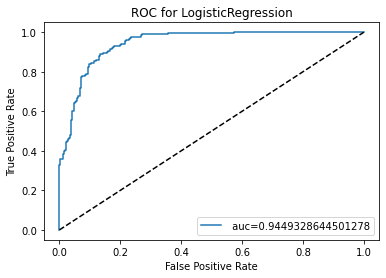

In [23]:
mdl_eva(X_test, y_test, lgr,'LogisticRegression')

### Build XGBClassaifier model

In [24]:
xgb = XGBClassifier(learning_rate=0.1,  max_depth= 5)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [25]:
pd.DataFrame(xgb.feature_importances_, 
             X_train.columns, 
             columns=['feature_importances'])\
            .sort_values(by='feature_importances', ascending=False)
                       
                         

,feature_importances
CLI_or_New_Prod_Flag,0.42259
Final_Limit,0.18205
Org_Struc_Desc,0.07023
Scored_Flag,0.04954
Financial_Template_Found_Flag,0.04817
Elan_Flag,0.04153
Other_NonBankCard,0.03557
CC_Score,0.03030
Revw_Quarter,0.02992
Scored_Rec_Decision,0.02648


XGBClassifier Model Evalation
Accuracy Score : 0.9824797843665768
Precision Score: 0.9758713136729222
Recall Score   : 0.9891304347826086
Auc Score      : 0.982533131829807
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       374
         1.0       0.98      0.99      0.98       368

    accuracy                           0.98       742
   macro avg       0.98      0.98      0.98       742
weighted avg       0.98      0.98      0.98       742

        pred:0  pred:1
true:0     365       9
true:1       4     364


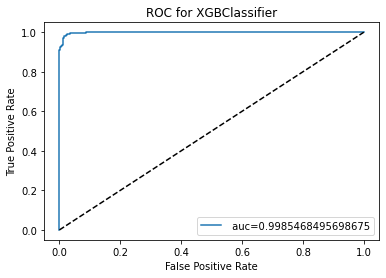

In [26]:
mdl_eva(X_test, y_test, xgb,'XGBClassifier')

In [27]:
sel = RFECV(estimator = XGBClassifier(learning_rate=0.1,  max_depth= 5), cv = 10, scoring = 'roc_auc')
sel.fit(X_test, y_test)

RFECV(cv=10,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, ...),
      scoring='roc_auc')

In [28]:
print(f'optimal number of features = {sel.n_features_}')

optimal number of features = 5


In [41]:
print(sel.support_)

[ True False  True False  True False False False False False False False
 False  True  True]


In [40]:
print(sel.estimators_)

AttributeError: 'RFECV' object has no attribute 'estimators_'

In [42]:
print(sel.grid_scores_)

[[0.78876245 0.81721195 0.74159357 0.64766082 0.7027027  0.78487947
  0.63038714 0.67567568 0.69247626 0.7330168 ]
 [0.95554765 0.99857752 0.99378655 0.97660819 0.98210373 0.96018992
  0.97516435 0.96018992 0.98392988 0.96018992]
 [0.98577525 0.99857752 0.99342105 0.98501462 0.97479912 0.96457268
  0.98283419 0.95325055 0.99123448 0.96274653]
 [0.98648649 0.99857752 0.99597953 0.99342105 0.9806428  0.97151205
  0.99707816 0.96639883 0.99561724 0.97808619]
 [1.         0.99893314 0.99780702 0.99707602 0.98721695 0.97552958
  0.99853908 0.96895544 0.99488678 0.97808619]
 [1.         0.99751067 0.99634503 0.99853801 0.9853908  0.96712929
  0.99853908 0.96785975 0.99561724 0.97297297]
 [1.         1.         0.99780702 0.99707602 0.98319942 0.96859021
  0.9963477  0.97443389 0.99853908 0.96785975]
 [1.         0.99857752 0.99853801 0.99853801 0.99050402 0.96128561
  0.99853908 0.96932067 0.99853908 0.96639883]
 [1.         0.99928876 0.99707602 0.99926901 0.98246896 0.96639883
  0.99853908

In [32]:
print(X_test.columns[sel.support_])

Index(['Org_Struc_Desc', 'Scored_Flag', 'CLI_or_New_Prod_Flag', 'Financial_Template_Found_Flag', 'Final_Limit'], dtype='object')


In [36]:
for i in range(X_test.shape[1]):
              print(f'Column:{i}, Select:{sel.support_[i]}, rank: {sel.ranking_[i]}')

Column:0, Select:True, rank: 1
Column:1, Select:False, rank: 5
Column:2, Select:True, rank: 1
Column:3, Select:False, rank: 6
Column:4, Select:True, rank: 1
Column:5, Select:False, rank: 4
Column:6, Select:False, rank: 11
Column:7, Select:False, rank: 10
Column:8, Select:False, rank: 9
Column:9, Select:False, rank: 7
Column:10, Select:False, rank: 8
Column:11, Select:False, rank: 3
Column:12, Select:False, rank: 2
Column:13, Select:True, rank: 1
Column:14, Select:True, rank: 1


In [38]:
for i in range(X_test.shape[1]):
              print(f'Column:{X_test.columns[i]}, Select:{sel.support_[i]}, rank: {sel.ranking_[i]}')

Column:Org_Struc_Desc, Select:True, rank: 1
Column:Revw_Quarter, Select:False, rank: 5
Column:Scored_Flag, Select:True, rank: 1
Column:Elan_Flag, Select:False, rank: 6
Column:CLI_or_New_Prod_Flag, Select:True, rank: 1
Column:Channel, Select:False, rank: 4
Column:Corporate_Card, Select:False, rank: 11
Column:Purchasing_Card, Select:False, rank: 10
Column:One_Card, Select:False, rank: 9
Column:Other_NonBankCard, Select:False, rank: 7
Column:Scored_Rec_Decision, Select:False, rank: 8
Column:SBFE_Score, Select:False, rank: 3
Column:CC_Score, Select:False, rank: 2
Column:Financial_Template_Found_Flag, Select:True, rank: 1
Column:Final_Limit, Select:True, rank: 1


In [43]:
sel_fea = sel.get_support(1)

In [44]:
sel_fea

array([ 0,  2,  4, 13, 14], dtype=int64)

In [ ]:

from sklearn.pipeline import Pipeline
rfe = RFECV(estimator = XGBClassifier(learning_rate=0.1,  max_depth= 5))
model = XGBClassifier(learning_rate=0.1,  max_depth= 5)
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

In [39]:

# automatically select the number of features for RFE
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset

# create pipeline
rfe = RFECV(estimator=XGBClassifier())
model =XGBClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.988 (0.007)
